In [151]:
from sqlalchemy.engine import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [152]:
df = pd.read_excel(r'table.xlsx')

In [153]:
df = df.drop_duplicates()

In [154]:
#создание общей таблицы с информацией по атрибутам
unique_percentage = (df.nunique()/df.shape[0] * 100).to_frame()
not_nan_percentage = (df.count()/df.shape[0]*100).to_frame()

unique_percentage.columns = ['unique_percentage']
not_nan_percentage.columns = ['not_nan_percentage']

unique_count = df.nunique().to_frame()
unique_count.columns = ['unique_count']

dtype = df.dtypes.to_frame()
dtype.columns = ['type']

null = df.isnull().sum().to_frame()
null.columns = ['null_count']

table_info = unique_percentage.join(not_nan_percentage)
table_info = table_info.join(dtype)
table_info = table_info.join(unique_count)
table_info = table_info.join(null)
table_info['percentage_sum'] = table_info.unique_percentage + table_info.not_nan_percentage
table_info = table_info.sort_values(by = 'percentage_sum', ascending = False).reset_index().rename(columns={'index':'column_name'})
table_info

,column_name,unique_percentage,not_nan_percentage,type,unique_count,null_count,percentage_sum
0,INSURANCESUM,60.820342,100.000000,float64,30353,0,160.820342
1,DT_ENDPLAN,14.741714,99.967940,object,7357,16,114.709654
2,INSUR_TERM,13.882098,99.979962,float64,6928,10,113.862061
3,PREMIUMSUM,47.777822,60.511762,float64,23844,19707,108.289584
4,ID_BRANCH,2.811285,100.000000,int64,1403,0,102.811285
5,CODE_DEPARTMENT,2.811285,100.000000,object,1403,0,102.811285
6,INSURANCEDEALTARIF,2.807278,100.000000,float64,1401,0,102.807278
7,DT_END_LASTPAYED,2.464634,100.000000,object,1230,0,102.464634
8,DT_START_LASTPAYED,0.811526,100.000000,object,405,0,100.811526
9,DT_BEGIN,0.723360,100.000000,object,361,0,100.723360


In [155]:
#получаем список всех атрибутов по приоритету
list_of_all_attributes = table_info['column_name'].tolist()
#получаем список атрибутов типа object
list_of_objects = table_info[table_info.type == 'object']['column_name'].tolist()

In [156]:
#выбор атрибута группировки
max_nulls = df.shape[0]*0.05
groupby_attr_1 = table_info.query('null_count <= @max_nulls and unique_count < 50 and unique_count != 1').sort_values(by = 'unique_count')['column_name'].tolist()
groupby_attr=groupby_attr_1[0]
groupby_attr

'INSURECASE_FLG'

In [157]:
#создание hash значений в атрибутах object
for attribute in list_of_objects:
    df[attribute] = df[df[attribute].isnull() == False][attribute].apply(lambda x: hash(x))

In [158]:
for attribute in list_of_all_attributes:
    #чистка выбросов по 2.5% и 97.5%
    q025 = df[attribute].quantile(0.025)
    q975 = df[attribute].quantile(0.975)
    df[~((df[attribute] < q025) | (df[attribute] > q975))]
    #заполнение пустот
    if df[attribute].isnull().sum() > 0:
        df[attribute]=df[attribute].fillna(df.groupby(groupby_attr)[attribute].transform('median'))
        df[attribute]=df[attribute].fillna(df[attribute].median())

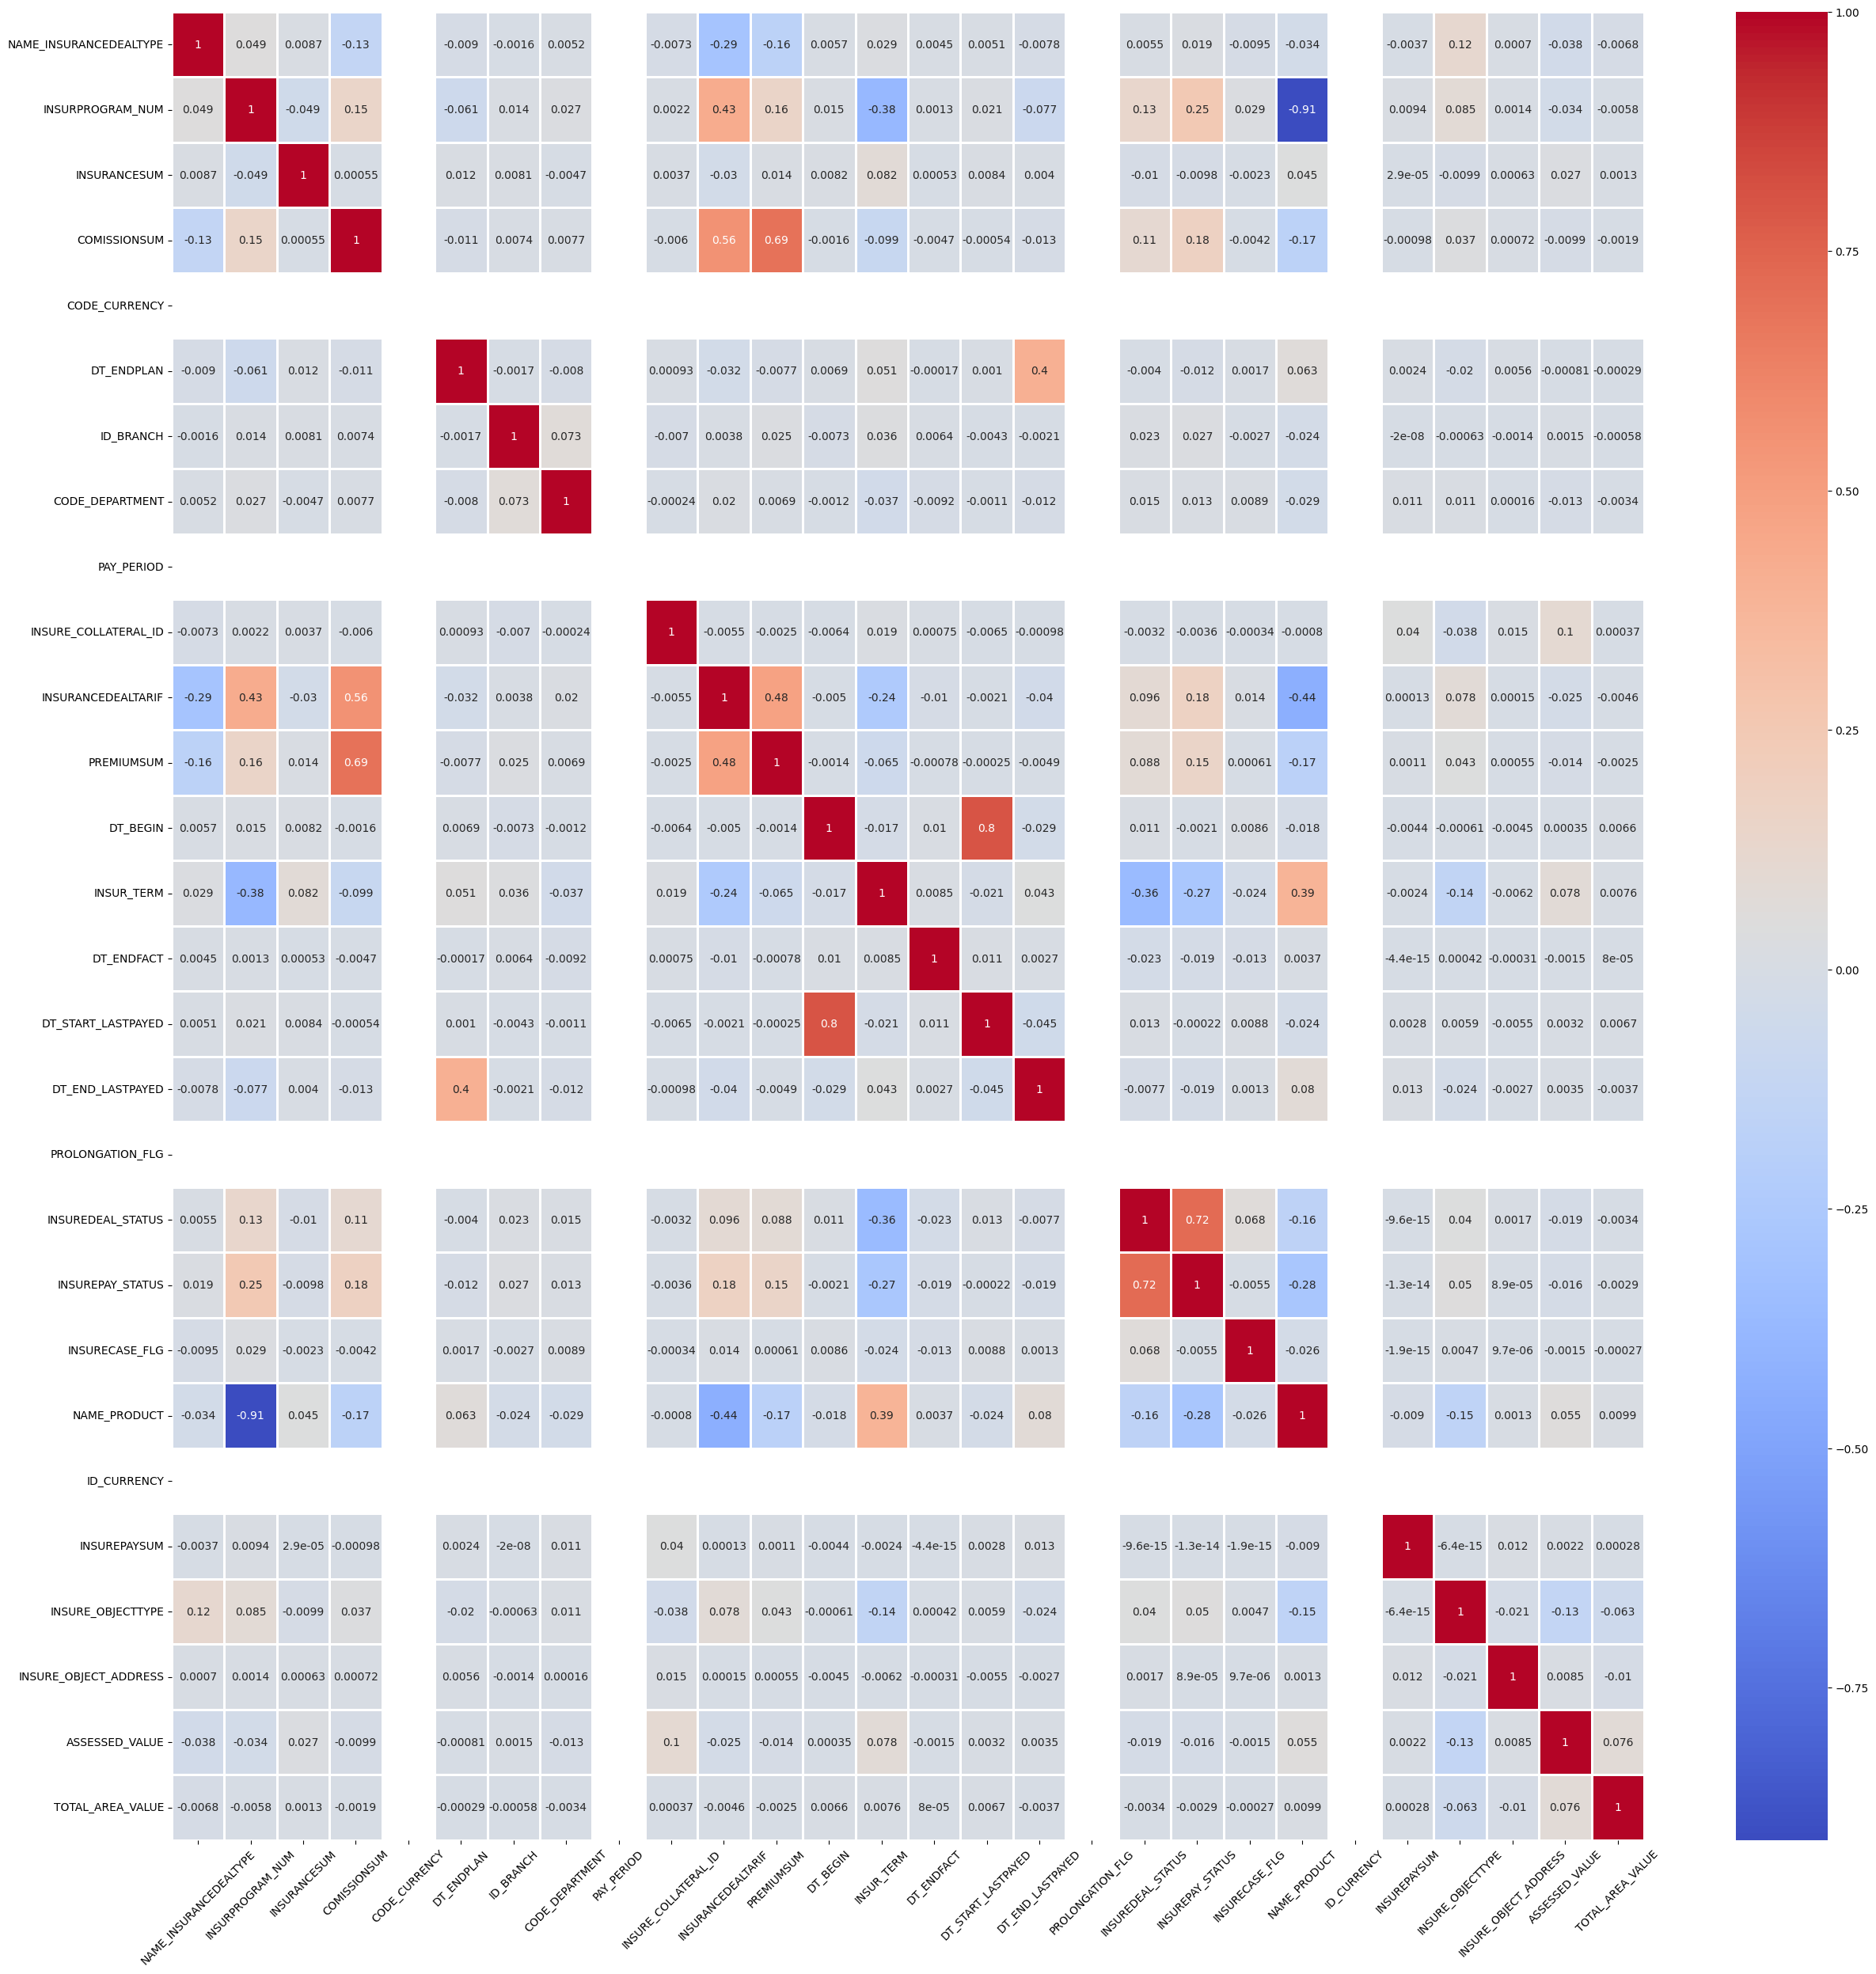

In [159]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),annot=True,linewidths=2,cmap='coolwarm')
plt.xticks(rotation = 45)
plt.show()